In [1]:
import json
from matplotlib import pyplot as plt
import numpy as np
import open3d as o3d
from src.EmbryoAlignment import Embryo
import seaborn as sns
from itertools import combinations
from sklearn.decomposition import PCA
from scipy.stats import median_abs_deviation
from scipy.spatial import KDTree, ConvexHull, Delaunay
from scipy.spatial.distance import pdist, squareform
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

with open('data/corresptissues.json') as f:
    corres_tissues = json.load(f)
    corres_tissues = {eval(k): v for k, v in corres_tissues.items()}
with open('data/tissuescolor.json') as f:
    colors_paper = json.load(f)
    colors_paper = {eval(k): v for k, v in colors_paper.items()}
%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2021-11-26 17:53:18,988 - utils - Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - 2021-11-26 17:53:18,989 - utils - NumExpr defaulting to 8 threads.


# Setting up parameters

In [2]:
# Path to the input data
data_path = '../SpatialSC/Data/E8.5.h5ad'
# Path to the output folder
output_folder = 'out/'

# Set of genes that will be interpolated
genes_of_interest = ['Cck', 'Cnn1', 'Hbb-bh1', 'Nppa', 'Nppb', 'Tdgf1', 'Thbs4', 'Tnni3']

# List of tissues that are ignored to do coverslip registration
tissues_to_ignore = [13, 15, 16, 22, 27, 29, 32, 36, 40, 41]

# Coverslips to ignore
# on the starting side
nb_CS_begin_ignore = 0
# on the ending side
nb_CS_end_ignore = 2

# Gives more weight to some tissues to help the alignment
tissue_weight = {21:1000, 18:1}
# xy resolution
xy_resolution = .6
# Distance max that two beads can be linked together between coverslips
th_d = 150
# Threshold bellow which the beads will be considered noise.
# Value between 0 (all beads taken) and 1 (almost no beads taken)
outlier_threshold = .1

# Number of interpolated layers between two consecutive coverslips
nb_interp = 5

# Loading the embryo

In [3]:
embryo = Embryo(data_path, tissues_to_ignore, corres_tissues, tissue_weight=tissue_weight,
                xy_resolution=xy_resolution, genes_of_interest=genes_of_interest,
                nb_CS_begin_ignore=nb_CS_begin_ignore, nb_CS_end_ignore=nb_CS_end_ignore,
                store_anndata=True)
embryo.removing_spatial_outliers(th=outlier_threshold)
embryo.reconstruct_intermediate(embryo, th_d=th_d, genes=genes_of_interest)

### Pre-processing the differential expression values
It can take a decent amount of time.

Moreover, it is likely that using a computer with decent amount of RAM is better

The list `tissues_to_process` contains the list of tissue ids that will be processed.

`th_vol` relates to the ratio of expressing cells over total number of cells for a given tissue. Any gene that have an expression volume ratio lower than `th_vol` or higher than `1-th_vol` is discarded.

Setting `th_vol` to `0` will consider all the genes. **It is not recommended.**

A value of `0.025` as in the following example means that the gene expression volume has to be higher than 2.5% and lower than 98.5% of the total volume of the tissue.

The function `get_3D_differential_expression` returns a Pandas dataframe that one could work with if wanted.

This dataframe can also be found later at `embryo.diff_expressed_3D`.

In [4]:
tissues_to_process = [5, 10, 12, 18, 21, 24, 30, 31, 33, 34, 39]
th_vol = .025
_ = embryo.get_3D_differential_expression(tissues_to_process, th_vol);

/home/guignard/workspace/scSpatial/src/EmbryoAlignment.py:938: RuntimeWarning: invalid value encountered in true_divide
  mean1 = np.cumsum(hist * bin_centers) / weight1
/home/guignard/workspace/scSpatial/src/EmbryoAlignment.py:939: RuntimeWarning: invalid value encountered in true_divide
  mean2 = (np.cumsum((hist * bin_centers)[::-1]) / weight2[::-1])[::-1]
/home/guignard/miniconda3/envs/SpatialSCII/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/guignard/miniconda3/envs/SpatialSCII/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


If one wants to add a tissue to the set of tissues already treated, it can be done easily and will be much faster since all the pre-processing is stored.

In [5]:
_ = embryo.get_3D_differential_expression([30], th_vol);

### Plotting the top `nb_genes` differentially expressed
The method `plot_top_3D_diff_expr_genes` allows to plot the top `nb_genes` that are spatially differentially expressed in a set of tissues `tissues_to_process`.

One can also allow or not gene repetition by changing the argument `repetition_allowed` from `False` to `True`. The default value is `False` meaning that repetitions are **not** allowed.

One can also decide to plot the original values or the z-scored values by changing the argument `compute_z_score`. Its value is `True` by default meaning that the z-score is plotted.

Ultimately, one can provide a matplotlib figure and a matplotib axis through the arguments `fig` and `ax`. By default none are specified and they are created within the function and returned by the function.

In [54]:
    def plot_top_3D_diff_expr_genes(self, tissues_to_process, nb_genes=20,
                                   repetition_allowed=False, compute_z_score=True,
                                   fig=None, ax=None):
        from collections import Counter
        tmp_T = set(tissues_to_process).difference(self.tissues_diff_expre_processed)
        if len(tmp_T) != 0:
            print("You asked to plot tissue(s) that were not already processed")
            print("The following tissue(s) will be ignored:")
            for t in tmp_T:
                print(f"\t - id: {t}, name: {self.corres_tissue[t]}")
        tissues_to_process = list(set(tissues_to_process).intersection(self.tissues_diff_expre_processed))
        genes_of_interest = []
        gene_dict = {}
        tissue_genes = {}
        genes_in = {}
        added_genes = 1 if repetition_allowed else 4
        for t in tissues_to_process:
            data_t = self.diff_expressed_3D[t]
            G_N = data_t.sort_values('Distance_to_reg')['Interesting genes'][:-nb_genes*added_genes-1:-1]
            G_V = data_t.sort_values('Distance_to_reg')['Distance_to_reg'][:-nb_genes*added_genes-1:-1]
            genes_of_interest.extend(G_N[:nb_genes])
            for g, v in zip(G_N, G_V):
                tissue_genes.setdefault(g, []).append(t)
                gene_dict[(t, g)] = v
            genes_in[t] = list(G_N)

        if not repetition_allowed:
            dict_counter = Counter(genes_of_interest)
            acc = 0
            while any([1<k for k in dict_counter.values()]):
                t = tissues_to_process[acc%len(tissues_to_process)]
                for g in genes_in[t]:
                    if 1<dict_counter[g]:
                        tissues = np.array(tissue_genes[g])
                        values = [gene_dict[(t, g)] for t in tissues]
                        if tissues[np.argsort(values)][-1]!=t:
                            genes_in[t].remove(g)
                genes_of_interest = []
                for t in tissues_to_process:
                    genes_of_interest.extend(genes_in[t][:nb_genes])
                dict_counter = Counter(genes_of_interest)
                acc += 1
        values = np.zeros((nb_genes*len(tissues_to_process), len(tissues_to_process)))
        tissue_order = []
        for i, g in enumerate(genes_of_interest):
            for j, t in enumerate(tissues_to_process):
                data_t = self.diff_expressed_3D[t]
                if g in data_t['Interesting genes'].values:
                    values[i, j] = data_t[data_t['Interesting genes']==g]['Distance_to_reg']
                if i==0:
                    tissue_order.append(t)
        # z_score = (values - np.mean(values, axis=1).reshape(-1, 1))/np.std(values, axis=1).reshape(-1, 1)
        if compute_z_score:
            z_score = stats.zscore(values, axis=0)
        if ax is None:
            fig, ax = plt.subplots(figsize=(5,max(5, round(1.5*nb_genes))))
        if fig is None:
            fig = ax.get_figure()
        ax.imshow(z_score, interpolation='nearest', cmap='Reds')
        ax.set_xticks(range(len(tissue_order)))
        ax.set_xticklabels([self.corres_tissue[t] for t in tissue_order], rotation=90)
        ax.set_yticks(range(values.shape[0]))
        ax.set_yticklabels(list(self.anndata[:,genes_of_interest].var_names))
        fig.tight_layout()
        return fig, ax

You asked to plot tissue(s) that were not already processed
The following tissue(s) will be ignored:
	 - 32


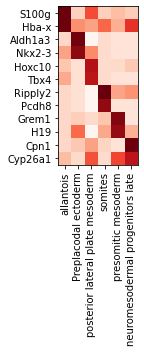

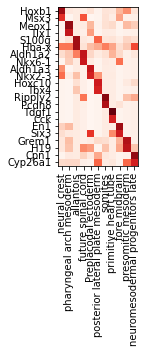

In [58]:
# Note that not all the tissues have to be plotted. Also, if a tissue asked
# has not already been computed, the function informs the user about it.
embryo.plot_top_3D_diff_expr_genes(tissues_to_process[:4]+[30, 31, 32], nb_genes=2);

# All the tissues plotted, 4 genes per tissues, repetition allowed,
# and the original values are plotted (not z-scored)
embryo.plot_top_3D_diff_expr_genes(tissues_to_process, nb_genes=2, repetition_allowed=False, z-);

,volume,avg_nb_neighbs,Distance_to_reg,Interesting genes,Gene names
160,0.092282,0.162121,0.225026,484,Cpn1
177,0.443512,0.310845,0.176951,529,Cyp26a1
601,0.082774,0.131757,0.172639,1859,Rhox5
323,0.135347,0.155992,0.169467,1082,Hes3
223,0.108501,0.140464,0.164661,656,Epcam
488,0.205817,0.184783,0.157684,1488,Nin
319,0.180649,0.171827,0.156442,1074,Hbb-bh1
748,0.029083,0.096154,0.153758,2237,Trap1a
389,0.151007,0.155556,0.152918,1200,Irx3
318,0.195190,0.171920,0.142091,1073,Hba-x


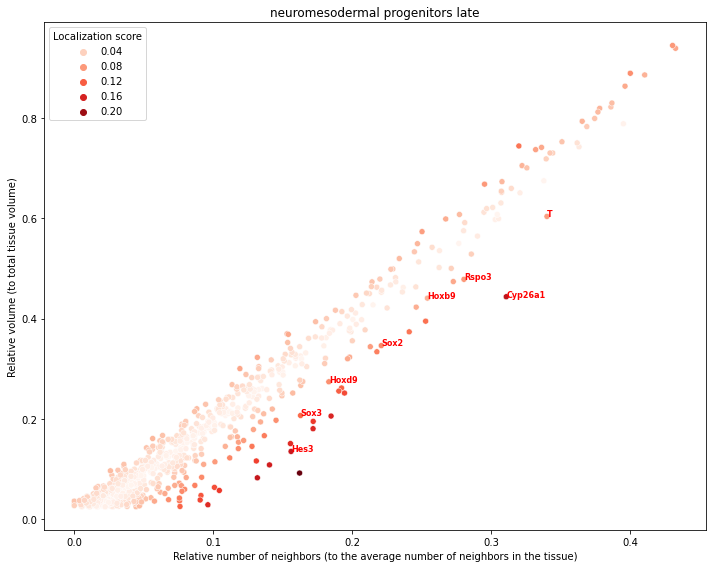

In [56]:
embryo.plot_volume_vs_neighbs(31, print_genes=['T', 'Sox2', 'Sox3',
                                               'Hes3', 'Hoxb9', 'Cyp26a1',
                                               'Rspo3', 'Hoxd9'],
                              path_to_fig='.', palette='Reds')
embryo.print_diff_expr_genes(tissue=31, nb=10)

# Defining the tissue and some parameters

In [ ]:
# Tissue
t = 21

# Looking for positions of low expression
invert = False

# Volume threshold below which genes are ignored
th_vol = 0.8*1e6

# Bead size (Might be wrong now but does not change the resulting genes)
bead_size = (10*10*30)

# Values against which the linear regression is done
# It is important that the relationship between x and y is linear!!!
# NOTE: For commodity; this value is redefined later
regression_x = 'avg_nb_neighbs'
regression_y = 'volume'

# Distance to the regression line above which a gene is considered an outlier
# (the higher the value is the more stringent the classifier is)
# NOTE: For commodity; this value is redefined later
th_pos = 7*1e6

# Preparing the data

In [ ]:
# Copying the data to make sure not to alter the original
data = embryo.anndata.copy().X
if invert:
    data = np.max(data) - data

# Computing the threshold value above which a cell is considered positive for a given gene expression value
# A unique threshold is computed for each gene assuming that within the embryo there are cells that express
# and cells that do not express (meaning that the threshold splits the distribution in two classes)
out = map(threshold_otsu, data.T)
th = []
for o in out:
    th += [o]
th = np.array(th)

# Cells from tissue *t*
cells = np.array([c for c in embryo.all_cells if embryo.tissue[c]==t])

# Splicing the array to only have tissue *t* cells
sub_data = data[cells]

# Total volume of the tissue (ie nb beads * bead size)
volume_total = len(cells) * bead_size

# Total volume of expressing cells
sub_volumes = np.sum(th<sub_data, axis=0) * bead_size

# Genes that have an expressing volume of at least th_vol
interesting_genes = np.where(th_vol<sub_volumes)[0]

# Computing the spatial metrics

In [ ]:
# Compute spatial metrics for the set of interesting genes
from multiprocessing import Pool
with Pool() as pool:
    out = pool.map(compute_vol_metrics, interesting_genes)
(avg_nb_neighbs, closest,
 diameter, med_min, med_max,
 med_dist, solidity) = [], [], [], [], [], [], []
for (av_n, close, dia, m_min, m_max, m_dist, soli) in out:
    avg_nb_neighbs.append(av_n)
    closest.append(close)
    diameter.append(dia)
    med_min.append(m_min)
    med_max.append(m_max)
    med_dist.append(m_dist)
    solidity.append(soli)
    
# Build a dataframe with the previously computed metrics
data_plot = {
    'volume log': np.log(sub_volumes[th_vol<sub_volumes]),
    'volume': sub_volumes[th_vol<sub_volumes],
    'volume ratio': sub_volumes[th_vol<sub_volumes]/volume_total,
    'avg_nb_neighbs': np.array(avg_nb_neighbs),
    'closest': np.array(closest),
    'diameter': np.array(diameter),
    'med_min': np.array(med_min),
    'med_max': np.array(med_max),
    'med_dist': np.array(med_dist),
    'solidity': np.array(solidity)
}

# Computing the linear regression to find the regionalized genes

In [ ]:
# Compute the linear regression
# Distance to the regression line above which a gene is considered an outlier
# (the higher the value is the more stringent the classifier is)
# It might be interesting to play with this value.
th_pos = 8*1e5

# Value against which the linear regression is done
# It is important that the relationship between x and y is linear!!!
regression_x = 'avg_nb_neighbs'
regression_y = 'volume'

regr = linear_model.LinearRegression()
data_x_reshaped = data_plot[regression_x].reshape(-1,1)
data_y_reshaped = data_plot[regression_y].reshape(-1,1)
regr.fit(data_x_reshaped, data_y_reshaped)
b = regr.intercept_[0]
a = regr.coef_[0][0]
line = lambda x: (a*np.array(x)+b)
X = np.linspace(np.min(data_plot[regression_x]), np.max(data_plot[regression_x]), 100)

data_plot['Distance_to_reg'] = np.abs((data_y_reshaped-regr.predict(data_x_reshaped))[:,0])
data_plot['Outlier\n(nb neighbs)'] = th_pos<data_plot['Distance_to_reg']

# Plotting the results

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
x = 'avg_nb_neighbs'
y = 'volume'
print_text = True
sns.scatterplot(data=data_plot, x=x, y=y, ax=ax, hue='Outlier\n(nb neighbs)')
if x==regression_x:
    ax.plot(X, line(X), '-')
not_to_take = lambda c: embryo.final[c][0]<0
found_g = set(embryo.anndata[:,interesting_genes[data_plot['Outlier\n(nb neighbs)']]].var_names)
print(found_g)

if print_text:
    for i, gene in enumerate(np.where(data_plot['Outlier\n(nb neighbs)'])[0]):
        txt = embryo.anndata[:,interesting_genes[gene]].var_names[0]
        plt.text(x=data_plot[x][gene]+.01,y=data_plot[y][gene],s=txt, 
                 fontdict=dict(color='red',size=8), va='baseline')
        
fig.tight_layout()
fig.savefig(f'{x}_{y}_{corres_tissues[t]}.pdf')

In [ ]:
sorted(found_g)